In [18]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [111]:
import numpy as np
import pandas as pd
import matplotlib as mp
from pickle import Pickler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import pykrige.ok 
from pykrige.ok import OrdinaryKriging
import scipy.interpolate
import math
from math import floor, log10
import matplotlib.animation as animation

import netCDF4 as nc
from salishsea_tools import  psu_tools
from seawater import eos80 

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

%matplotlib inline

# Which waters is L3 2009 station made of? Calculation of mixing rate

In [112]:
import Data

data,sta,date,lon,lat,P,d,t,s,theta,Tpot,Tr,fluo,oxy_uM,oxy_mL,rho,isop,si,ti,NO3_1,NO3_2,PO3_1,PO3_2,SiO4_1,SiO4_2,nut = Data.AllData_variables()
PaThData,PaTh_sta,PaTh_lon,PaTh_lat,PaTh_t,PaTh_s,PaTh_theta,PaTh_rho,PaTh_d = Data.PaTh_variables()
listAllSta,listPaThSta,PaThDataSorted,PaThSort_sta,PaThSort_d,Pa,Th,PaTh,PaErr,ThErr,PaThErr = Data.PaTh_varSorted()

/home/mgrenier/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (0,10,11,28,30,31,32,33,34,35,36,37,38,39,41,42,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/ocean/mgrenier/geotraces/analysis-Melanie/notebooks/Geotraces2015data/Data.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data.Tpot[thetaOnly] = data.theta[thetaOnly]
/ocean/mgrenier/geotraces/analysis-Melanie/notebooks/Geotraces2015data/DerivVar.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  isop = np.zeros((ydim,xdim))


453.0 13.0


/home/mgrenier/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: DtypeWarning: Columns (0,10,11,28,30,31,32,33,34,35,36,37,38,39,41,42,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


453.0 13.0
453.0 13.0


/home/mgrenier/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DtypeWarning: Columns (0,10,11,28,30,31,32,33,34,35,36,37,38,39,41,42,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.


453.0 13.0


In [113]:
### open bathymetry file and define the variables needed
etopo1 = nc.Dataset('/ocean/mgrenier/geotraces/research/ModelEval/BathyArctic/ETOPO1_Bed_g_gmt4.grd')
# Define numpy array 
lon_etopo = etopo1.variables['x'][:]
lat_etopo = etopo1.variables['y'][:]
bathy_etopo = etopo1.variables['z'][:]
llon, llat = np.meshgrid(lon_etopo, lat_etopo)

In [114]:
### Listing the Pa/Th stations
ind = PaTh_lon.index.tolist()
listPaThLon = []
listPaThLat = []
listPaThSta = []
listPaThDate = []

for i in range(0,len(PaTh_lon),1):
#    if (PaTh_lon[ind[i]] not in listPaThLon):
    if ((PaTh_lon[ind[i]] not in listPaThLon) & (PaTh_lat[ind[i]] not in listPaThLat) 
        & (PaTh_sta[ind[i]] not in listPaThSta)):
        listPaThLon.append(PaTh_lon[ind[i]].tolist())
        listPaThLat.append(PaTh_lat[ind[i]].tolist())
        listPaThSta.append(PaTh_sta[ind[i]])
        listPaThDate.append(PaThData.date[ind[i]])


In [115]:
listPaThSta[32:38], listPaThDate[32:38],listPaThLon[32:38],listPaThLat[32:38]
#data.head()

(['152', '165', '173', '176', '208', '239'],
 ['1991-08-15T00:00:00.00',
  '1991-08-15T00:00:00.00',
  '1991-08-15T00:00:00.00',
  '1991-08-15T00:00:00.00',
  '1991-08-15T00:00:00.00',
  '1991-08-15T00:00:00.00'],
 [30.4133, 60.385, 108.985, 158.8633, -5.0933, 8.6067],
 [83.975, 87.5733, 87.7533, 88.0, 86.15, 83.2317])

In [116]:
var = pd.read_pickle('/home/mgrenier/Documents/Data_Arctic/WorldOceanDatabase/18Oct16-64N90N-CTD/WOD1991')
ind = var.Lon.index.tolist()
matchWOD1991 = pd.DataFrame()

for i in range(0,len(listPaThDate)-1,1):
    if (listPaThDate[i].startswith('1991') == True):
        mlon_Data = listPaThLon[i]
        mlat_Data = listPaThLat[i]
        find = var[(abs(var.Lon-mlon_Data) < 2) & (abs(var.Lat-mlat_Data) < 2)]           
        matchWOD1991 = pd.concat([matchWOD1991,find])

In [117]:
#matchWOD1991[(matchWOD1991.Lon <10) & (matchWOD1991.Lon > 0)]
matchWOD1991.rename(columns={'Date':'date','Lon':'lon','Lat':'lat'}, inplace= True)

In [118]:
addCTD91 = pd.concat([data,matchWOD1991])
addCTD91 = addCTD91.reindex_axis(data.columns, axis=1)
data = addCTD91

In [119]:
sta = data.Station
t = data.temp
s = data.sal
d = data.d

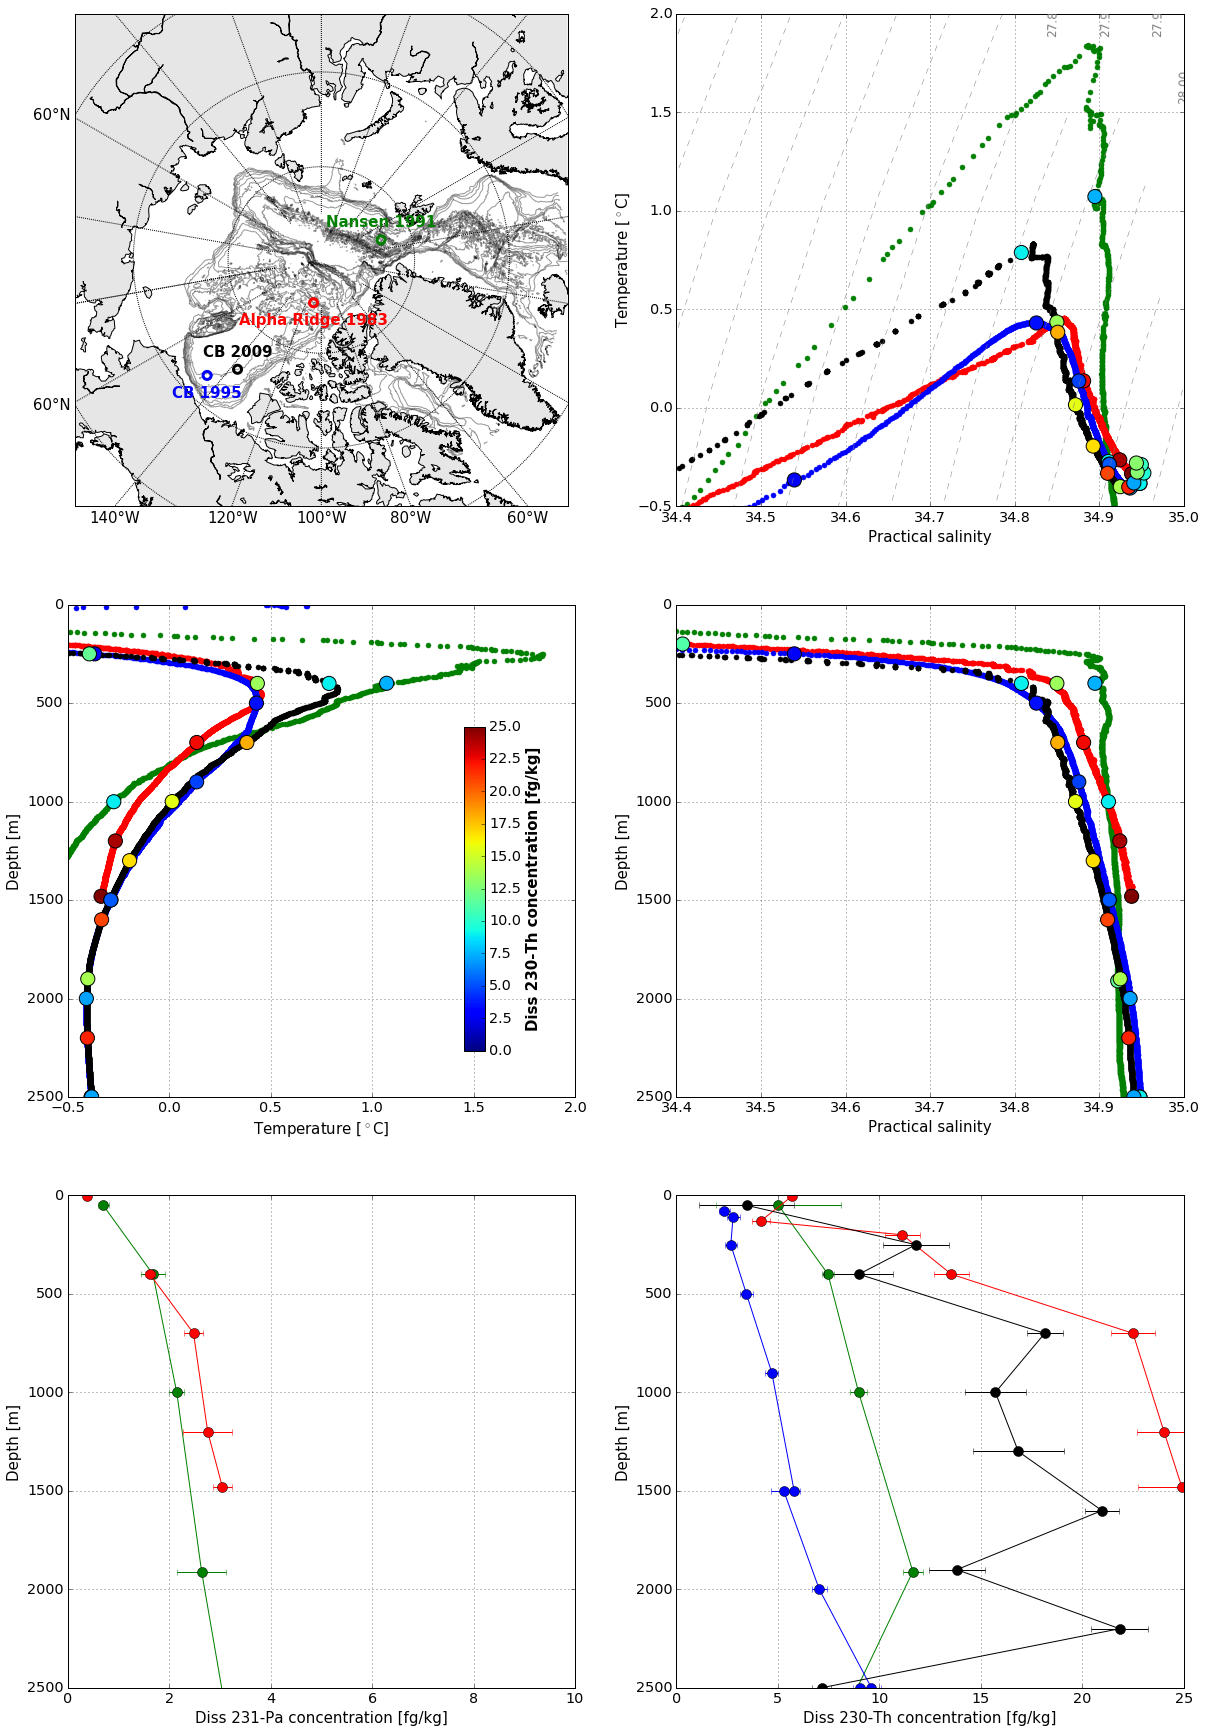

In [169]:
Nansen_concat = pd.DataFrame()
P_corresp=PaThDataSorted.P[PaThSort_sta == '239'].tolist()
Nansen = data[(sta == 3392994)]
for i in range (0,len(P_corresp),1):
    find_closest = (Nansen.P-P_corresp[i]).abs().argsort()[:1]
    ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
    Nansen_closest = Nansen[Nansen.index == ind_closest.tolist()]
    Nansen_concat = pd.concat([Nansen_concat,Nansen_closest])

fig,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,facecolor='w',figsize=(20,30))
m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,round=False,resolution='l',ax=ax1)
m.drawcoastlines()
x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
mp.rcParams['contour.negative_linestyle'] = 'solid'
clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]
m.fillcontinents(color = '0.9',alpha=1,zorder = 1)
m.drawparallels(np.arange(50.,90.,10.),labels=[1, 0, 0, 0],fontsize=15,zorder=1)
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,fontsize=15,zorder=1)
m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)

CS=ax2.contour(si,ti,isop,605, linestyles='dashed',linewidths = 0.5, colors='grey')
ax2.clabel(CS, fontsize=12, inline=1, fmt='%0.2f') # Label every second level

for station,name,hpos,vpos,C in zip((3392994,'CTD-4915','A01-95','L3-2009'),
                                    ('Nansen 1991\n\n','\n\nAlpha Ridge 1983','\n\nCB 1995','CB 2009\n\n'),
                                    ('center','center','center','center'),
                                    ('center','center','center','center'),
                                    ('g','r','b','k')):

    for ax,xfield,yfield,xlabels,ylabels,xranges,yranges in zip((ax2,ax3,ax4),(s,t,s),
                                    (t,d,d),
                                    ('Practical salinity','Temperature [$^\circ$C]','Practical salinity'),
                                    ('Temperature [$^\circ$C]','Depth [m]','Depth [m]'),
                                    ([34.4, 35.0],[-0.5,2.0],[34.4, 35.0]),
                                    ([-0.5,2.0],[0,2500],[0,2500])):
        ax.plot(xfield[sta == station],yfield[sta == station],'.',markersize=10,color=C,label=name,zorder=-1)
        ax.set_xlim(xranges)
        ax.set_ylim(yranges)
        ax.set_xlabel(xlabels,size=15)
        ax.set_ylabel(ylabels,size=15)
        ax.invert_yaxis()
        


ax2.invert_yaxis()

for station,name,hpos,vpos,C in zip(('239','CTD-4915','A01-95','L3-2009'),
                            ('Nansen 1991\n\n','\n\nAlpha Ridge 1983','\n\nCB 1995','CB 2009\n\n'),
                            ('center','center','center','center'),
                            ('center','center','center','center'),
                             ('g','r','b','k')):
    for i in range(0,len(listPaThDate)-1,1):
        if (listPaThSta[i] == station):
            mlon_Data,mlat_Data = m(listPaThLon[i],listPaThLat[i])
            ax1.scatter(mlon_Data,mlat_Data,marker='o',facecolors='none',linewidth='3',edgecolors=C,s=65,zorder=1)
            ax1.annotate(name,xy=(mlon_Data,mlat_Data),fontsize=15,color=C,fontweight='bold',
                        horizontalalignment=hpos,verticalalignment=vpos)

    for ax,xfield,yfield,XERR,xlabels,ylabels,xranges,yranges in zip((ax5,ax6),(Pa,Th),
                                    (PaThSort_d,PaThSort_d),
                                    (PaErr,ThErr),                                 
                                    ('Diss 231-Pa concentration [fg/kg]','Diss 230-Th concentration [fg/kg]'),
                                    ('Depth [m]','Depth [m]'),
                                    ([0, 10],[0,25]),
                                    ([0,2500],[0,2500])):
        ax.plot(xfield[PaThSort_sta == station],yfield[PaThSort_sta == station],'o-',markersize=10,color=C,label=name)
        ax.errorbar(xfield[PaThSort_sta == station],yfield[PaThSort_sta == station],
                     xerr=XERR[PaThSort_sta == station].tolist(),color=C,fmt='.',label='_nolegend_')
        ax.set_xlim(xranges)
        ax.set_ylim(yranges)
        ax.set_xlabel(xlabels,size=15)
        ax.set_ylabel(ylabels,size=15)
        ax.invert_yaxis()
    
    for ax,xfield,yfield,xNans,yNans in zip((ax2,ax3,ax4),
                                            (PaThDataSorted.sal,PaThDataSorted.temp,PaThDataSorted.sal),
                                            (PaThDataSorted.temp,PaThDataSorted.d,PaThDataSorted.d),
                                            (Nansen_concat.sal,Nansen_concat.temp,Nansen_concat.sal),
                                            (Nansen_concat.temp,Nansen_concat.d,Nansen_concat.d)):
        if station != '239':    
            ax.scatter(xfield[PaThSort_sta == station],yfield[PaThSort_sta == station],
                        c=Th[PaThSort_sta == station].tolist(),marker='o',s=200,vmin=0,vmax=25,zorder=1)
        if station == '239': 
            SC=ax.scatter(xNans,yNans,c=Th[PaThSort_sta == station].tolist(),marker='o',s=200,vmin=0,vmax=25,zorder=1)
cbar_ax = fig.add_axes([0.40, 0.42, 0.015, 0.15])        
CBar = plt.colorbar(SC,cax=cbar_ax, orientation='vertical') 
CBar.set_label(label='Diss 230-Th concentration [fg/kg]',size=15,weight='bold')

for ax, in zip((ax2,ax3,ax4,ax5,ax6)):
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_axisbelow(True)


In [151]:
Nansen_concat = pd.DataFrame()
data.tail()
#station,xfield,yfield
data[sta == 3392994]
Pa[PaThSort_sta == 'L3-2009']
PaThDataSorted.sal[PaThSort_sta == station],PaThDataSorted.temp[PaThSort_sta == station]
Th[PaThSort_sta == station].tolist()
P_corresp=PaThDataSorted.P[PaThSort_sta == '239'].tolist()
P_corresp
Nansen = data[(sta == 3392994)]
for i in range(0,len(P_corresp),1):
    find_closest = (Nansen.P-P_corresp[i]).abs().argsort()[:1]
    ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
    Nansen_closest = Nansen[Nansen.index == ind_closest.tolist()]
    Nansen_concat = pd.concat([Nansen_concat,Nansen_closest])
Nansen_concat
#len(P_corresp),P_corresp[5]

,Cruise,Station,Type,date,lon,lat,z_bottom,P,d,Cast,Cast name,Pressure,Pa,PaErr,Th,ThErr,PaTh,PaThErr,231-Pa Tot (fg/kg),231-Pa Tot error,230-Th Tot (fg/kg),230-ThTot error,eNd,Erreur sur eNd,[Nd]pmol/kg,rho,Erreur sur [Nd],Nd/yb,Ce/Ce*,temp,transmi,fluo,sal,dens,SPVA_01 [m**3/kg],Tpot,VAIS_01 [s^-2],SIGO_01 [kg/m**3],theta,SIGP_01 [kg/m**3],FRET_01 [degrees C],DOXY_01 [ml/l],CDOM_01 [mg/m**3],NTRA_01 [mmol/m**3],PSAR_01 [ueinsteins/s/m**2],SPAR_01 [ueinsteins/s/m**2],ASAL [g/kg],CONT [deg C],D_CT [kg/m^3],D0CT [kg/m^3],Conductivity [uS/cm],Oxy_uM,Oxy_mL,"Oxygen, SBE 43 [% saturation]","Oxygen Saturation, Garcia & Gordon [ml/l]","Oxygen Saturation, Weiss [ml/l]","Oxygen raw, SBE 43 [V]",flag,Cast-nut,Press,Nitrite-1 [?mol/L],Nitrite-2 [?mol/L],NO3_1,NO3_2,PO3_1,PO3_2,SiO4_1,SiO4_2,Ammonium-1 [?mol/L],Ammonium-2 [?mol/L],Extracted Chlorophyll a (ug/l),Extracted Phaeo-pigment (ug/l),Unnamed: 70,Unnamed: 71,Chlorophyll a (Fluorometer) mg/m^3
32851776,WOD13_SE,3392994,NaN,1991-09-25T10:22,8.285,83.345,3730.0,51.96,51.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.302346,NaN,NaN,NaN,-1.78,NaN,NaN,33.92,NaN,NaN,-1.780976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32851952,WOD13_SE,3392994,NaN,1991-09-25T10:22,8.285,83.345,3730.0,404.00,399.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.956289,NaN,NaN,NaN,1.072,NaN,NaN,34.895,NaN,NaN,1.052528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32852257,WOD13_SE,3392994,NaN,1991-09-25T10:22,8.285,83.345,3730.0,1013.96,1000.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.048631,NaN,NaN,NaN,-0.273,NaN,NaN,34.911,NaN,NaN,-0.316131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32852720,WOD13_SE,3392994,NaN,1991-09-25T10:22,8.285,83.345,3730.0,1939.96,1910.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.079672,NaN,NaN,NaN,-0.746,NaN,NaN,34.922,NaN,NaN,-0.836997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32853231,WOD13_SE,3392994,NaN,1991-09-25T10:22,8.285,83.345,3730.0,2961.94,2909.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.090908,NaN,NaN,NaN,-0.781,NaN,NaN,34.934,NaN,NaN,-0.944991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32853601,WOD13_SE,3392994,NaN,1991-09-25T10:22,8.285,83.345,3730.0,3701.99,3630.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.093701,NaN,NaN,NaN,-0.715,NaN,NaN,34.941,NaN,NaN,-0.944252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Mixing equation, considering T, S and Th
<h3>
$
\begin{cases}
    \alpha_1\cdot T_1 + \alpha_2\cdot T_2 + \alpha_3\cdot T_3 = T_m\\
    \alpha_1\cdot S_1 + \alpha_2\cdot S_2 + \alpha_3\cdot S_3 = S_m\\
    \alpha_1\cdot Th_1 + \alpha_2\cdot Th_2 + \alpha_3\cdot Th_3 = Th_m
\end{cases}
$

### Expression of the mixing coefficients A1, A2 and A3
<h2>
$
\begin{cases}
\alpha_1 = \frac{(T_m\cdot Th_3 - Th_m\cdot T_3)\cdot (Th_3\cdot S_2-Th_2\cdot S_3)+(Th_3\cdot S_m - Th_m\cdot S_3)\cdot (Th_2\cdot T_3-Th_3\cdot T_2)}{(T_1\cdot Th_3 - T_3\cdot Th_1)\cdot (Th_3\cdot S_2 - Th_2\cdot S_3)+(Th_3\cdot T_2 - Th_2\cdot T_3)\cdot (Th_1\cdot S_3 - Th_3\cdot S_1)}\\
\alpha_2 = \frac{Th_3\cdot S_m - Th_m\cdot S_3 + \alpha_1\cdot (Th_1\cdot S_3 - Th_3\cdot S_1)}{Th_3\cdot S_2 - Th_2\cdot S_3}\\
\alpha_3 = \frac{Th_m - \alpha_1\cdot Th_1 - \alpha_2\cdot Th_2}{Th_3}
\end{cases}
$

### Matricial writing and solving
$
\begin{pmatrix}
        T_1 & T_2 & T_3 \\
        S_1 & S_2 & S_3 \\
        Th_1 & Th_2 & Th_3 \\
\end{pmatrix}
$ 
$\cdot$
$
\begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \alpha_3 \\
\end{pmatrix}
$
$=$
$
\begin{pmatrix}
        T_m \\
        S_m \\
        Th_m \\
\end{pmatrix}\\
$

$   =>   $
$
\begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \alpha_3 \\
\end{pmatrix}
$
$=$
$
\begin{pmatrix}
        T_1 & T_2 & T_3 \\
        S_1 & S_2 & S_3 \\
        Th_1 & Th_2 & Th_3 \\
\end{pmatrix}^{-1}
$ 
$\cdot$
$
\begin{pmatrix}
        T_m \\
        S_m \\
        Th_m \\
\end{pmatrix}
$


## Endmember parameters
<h3>
- Endmember #1: Atlantic water 1991 @ station 3392994 (WOD2013) for $T_1$ and $S_1$ and @ station 239 (ARKVIII-3; Scholten et al., 1995) for $Th_1$
- Endmember #2: Canada Basin water 1995 @ CTD 50 (station AO-1, Louis St Laurent 95) for $T_2$ and $S_2$ and @ AO-1 station (Edmonds et al., 1998) for $Th_2$
- Endmember #3: Alpha Ridge water 1983 @ CTD 109 (CESAR) for $T_3$ and $S_3$ and $Th_3 $ (Bacon et al., 1989)
- Mixed water : Canada Basin water @ station L3 (2009), depth = 400 m, for $T_m$, $S_m$ and $Th_m $

### Temperature, in degrees Celsius
$
T_1 = 1.072\\
T_2 = 0.43\\
T_3 = 0.436\\
T_m = 0.788
$
### Practical salinity
$
S_1 = 34.895\\
S_2 = 34.826\\
S_3 = 34.848\\
S_m = 34.808
$
### Dissolved 230Th concentrations, in fg/kg
$
Th_1 = 7.47\\
Th_2 = 3.45\\
Th_3 = 13.52\\
Th_m = 8.99
$
### Associated depths of the samples, in m
$
d_1 = 400\\
d_2 = 500\\
d_3 = 400\\
d_m = 400
$

In [160]:
T1 = 1.072
T2 = 0.43
T3 = 0.436
Tm = 0.788

### Practical salinity

S1 = 34.895
S2 = 34.826
S3 = 34.848
Sm = 34.808

### Dissolved 230Th concentrations, in fg/kg

Th1 = 7.47
Th2 = 3.45
Th3 = 13.52
Thm = 8.99

### Associated depths of the samples, in m

d1 = 400
d2 = 500
d3 = 400
dm = 400


In [161]:
import numpy as np
a = np.array([[T1,T2,T3], [S1,S2,S3], [Th1,Th2,Th3]])
b = np.array([Tm,Sm,Thm])
x = np.linalg.solve(a, b)
x,x[0],x[1]

(array([ 0.55578141,  0.11348936,  0.32890344]),
 0.55578141268918246,
 0.11348935830736231)

In [162]:
A1 = x[0]
A2 = x[1]
A3 = x[2]

In [163]:
print(' A1 =', '{:.0%}'.format(A1), '    Atlantic Water','\n'
      ,'A2 =', '{:.0%}'.format(A2), '    1995 Canada Basin water','\n',
      'A3 =', '{:.0%}'.format(A3), '    Alpha Ridge water','\n',
      'A1 + A2 + A3 =', '{:.0%}'.format(A1+A2+A3))

 A1 = 56%     Atlantic Water 
 A2 = 11%     1995 Canada Basin water 
 A3 = 33%     Alpha Ridge water 
 A1 + A2 + A3 = 100%


# 2nd calculation, with another Atlantic Water endmember
## Endmember parameters
<h3>
- Endmember #1: Atlantic water 1991 @ CTD 109 (ARKVIII-2) for $T_1$ and $S_1$ and @ station 152 (ARKVIII-3; Scholten et al., 1995) for $Th_1$
- Endmember #2: Canada Basin water 1995 @ CTD 50 (station AO-1, Louis St Laurent 95) for $T_2$ and $S_2$ and @ AO-1 station (Edmonds et al., 1998) for $Th_2$
- Endmember #3: Alpha Ridge water 1983 @ CTD 109 (CESAR) for $T_3$ and $S_3$ and $Th_3 $ (Bacon et al., 1989)
- Mixed water : Canada Basin water @ station L3 (2009), depth = 400 m, for $T_m$, $S_m$ and $Th_m $

### Temperature, in degrees Celsius
$
T_1 = 1.54\\
T_2 = 0.43\\
T_3 = 0.436\\
T_m = 0.788
$
### Practical salinity
$
S_1 = 34.933\\
S_2 = 34.826\\
S_3 = 34.848\\
S_m = 34.808
$
### Dissolved 230Th concentrations, in fg/kg
$
Th_1 = 6.91\\
Th_2 = 3.45\\
Th_3 = 13.52\\
Th_m = 8.99
$
### Associated depths of the samples, in m
$
d_1 = 500\\
d_2 = 500\\
d_3 = 400\\
d_m = 400
$

In [159]:
T1 = 1.54
T2 = 0.43
T3 = 0.436
Tm = 0.788

### Practical salinity

S1 = 34.933
S2 = 34.826
S3 = 34.848
Sm = 34.808

### Dissolved 230Th concentrations, in fg/kg

Th1 = 6.91
Th2 = 3.45
Th3 = 13.52
Thm = 8.99

### Associated depths of the samples, in m

d1 = 500
d2 = 500
d3 = 400
dm = 400


In [5]:
import numpy as np
a = np.array([[T1,T2,T3], [S1,S2,S3], [Th1,Th2,Th3]])
b = np.array([Tm,Sm,Thm])
x = np.linalg.solve(a, b)
x,x[0],x[1]

(array([ 0.3208312 ,  0.23686479,  0.44052314]),
 0.32083120147399558,
 0.2368647911317186)

In [6]:
A1 = x[0]
A2 = x[1]
A3 = x[2]

In [7]:
print(' A1 =', '{:.0%}'.format(A1), '    Atlantic Water','\n'
      ,'A2 =', '{:.0%}'.format(A2), '    1995 Canada Basin water','\n',
      'A3 =', '{:.0%}'.format(A3), '    Alpha Ridge water','\n',
      'A1 + A2 + A3 =', '{:.0%}'.format(A1+A2+A3))

 A1 = 32%     Atlantic Water 
 A2 = 24%     1995 Canada Basin water 
 A3 = 44%     Alpha Ridge water 
 A1 + A2 + A3 = 100%


In [8]:
A1*Th1 + A2*Th2 + A3*Th3
#A1*S1 + A2*S2 + A3*S3
#A1*T1 + A2*T2 + A3*T3

8.9900000000000002

In [27]:
del A1,A2,A3

# Mixing equation, considering T and S only
<h3>
$
\begin{cases}
    \alpha_1*T_1 + \alpha_2*T_2 + \alpha_3*T_3 = T_m\\
    \alpha_1*S_1 + \alpha_2*S_2 + \alpha_3*S_3 = S_m\\
    \alpha_1 + \alpha_2 + \alpha_3 = 1
\end{cases}
$

### Expression of the mixing coefficients A1, A2 and A3
<h2>
$
\begin{cases}
\alpha_1 = \frac{T_m\cdot (S_2-S_3)+T_2\cdot (S_3-S_m)+T_3\cdot(S_m-S_2)}{T_1\cdot(S_2-S_3)+T_2\cdot(S_3-S_1)+T_3\cdot(S_1-S_2)}\\
\alpha_2 = \frac{S_m-S_3+\alpha_1\cdot(S_3-S_1)}{S_2-S_3}\\
\alpha_3 = 1-\alpha_1-\alpha_2
\end{cases}
$

### Matricial writing and solving
$
\begin{pmatrix}
        T_1 & T_2 & T_3 \\
        S_1 & S_2 & S_3 \\
        1 & 1 & 1 \\
\end{pmatrix}
$ 
$\cdot$
$
\begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \alpha_3 \\
\end{pmatrix}
$
$=$
$
\begin{pmatrix}
        T_m \\
        S_m \\
        1 \\
\end{pmatrix}\\
$

$   =>   $
$
\begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \alpha_3 \\
\end{pmatrix}
$
$=$
$
\begin{pmatrix}
        T_1 & T_2 & T_3 \\
        S_1 & S_2 & S_3 \\
        1 & 1 & 1 \\
\end{pmatrix}^{-1}
$ 
$\cdot$
$
\begin{pmatrix}
        T_m \\
        S_m \\
        1 \\
\end{pmatrix}
$


In [11]:
a = np.array([[T1,T2,T3], [S1,S2,S3], [1,1,1]])
b = np.array([Tm,Sm,1])
x = np.linalg.solve(a, b)
x,x[0],x[1]

(array([ 0.33577256,  3.1154849 , -2.45125746]),
 0.33577256287324536,
 3.1154849020104809)

In [12]:
A1 = x[0]
A2 = x[1]
A3 = x[2]

In [13]:
print(' A1 =', '{:.0%}'.format(A1),'\n','A2 =', '{:.0%}'.format(A2),'\n',
      'A3 =', '{:.0%}'.format(A3),'\n','A1 + A2 + A3 =', '{:.0%}'.format(A1+A2+A3))

 A1 = 34% 
 A2 = 312% 
 A3 = -245% 
 A1 + A2 + A3 = 100%
